# Assignment 2: Deep learning for texture synthesis - Part 2
Aurélie Bugeau 
_Credits: Ryan Webster and Julien Rabin (Ensicaen)_

The goal of this assignment is to perform texture synthesis with deep learning. There are three parts to this assignement: 
 1. Have a closer look at a deep classification network (VGG-19) [1]
 2. Implement and test the texture synthesis with a generative network method of [2]
 
 [1] K. Simonyan, A. Zisserman. "Very Deep Convolutional Networks for Large-Scale Image Recognition", arXiv:1409.1556, 2014  
 [2] Ulyanov, Lebedev, Vedaldi, Lempitsky. "Texture Networks: Feed-forward Synthesis of Textures and Stylized Images", ICML, 2016  

In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from my_utils import *


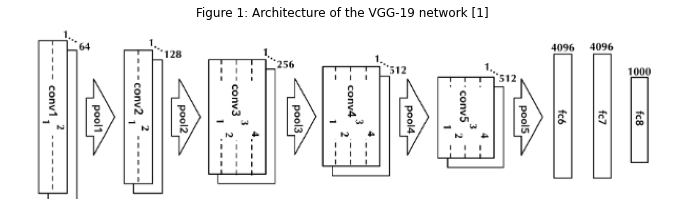

In [2]:
#Plot Figure 1 with caption
plotImage(Image.open("./VGG-19.png"),"Figure 1: Architecture of the VGG-19 network [1]", figsize_=(12,8))

The network is defined is file *Models_VGG/vgg.py*. Let us load it.

In [3]:
# Load modules
import torch
import torchvision
import torch.nn as nn
from VGG_Models.vgg import get_vgg_net
import numpy as np


In [4]:

vgg_net = get_vgg_net()
for param in vgg_net.parameters():
    param.requires_grad = True
print(vgg_net)



VGG(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512,

#### <font color='red'> Question 1 </font>
Open an image and run a forward pass of the VGG-19 network over it. Visualize and justify the feature sizes 

(64, 64)


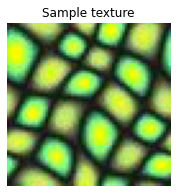

torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 256, 16, 16])
torch.Size([1, 512, 8, 8])
torch.Size([1, 512, 4, 4])


In [30]:
# Open an image 
sample = Image.open('Images/text1.jpg')
print(sample.size)
sample = sample.resize((64,64))  #You may uncomment this line
plotImage(sample,"Sample texture", figsize_=(3,3))

# Convert it to a tensor
sample = prep(sample).unsqueeze(0)
sample.require_grad = False


if torch.cuda.is_available():
    print("CUDA ON")
    sample = sample.cuda()

sample_feats = vgg_net(sample) #similar to vgg_net.forward(tens)
sample_feats = [out.detach() for out in sample_feats]#.detach to avoid tracking the gradients of this variable
# Visualize sizes of network RELU activations 
for feat in sample_feats:
     print(feat.size())

Le réseau vgg-19 est composé de 5 layers différents. Ces 5 layers sont des couches de convolution de taille 64, 128, 256, 512, 512. Par conséquent, les features ont la même profondeur que ces couches de convolutions. De plus, après chaque couches convolutionnelles, on a une couche de Max-Pooling ce qui a pour effet de diviser la taille de l'élement d'entrée par 2 à chaque fois. Par conséquent, les dimensions largeur-hauteur des featuers est 64*64 (taille initiale) -> 32 * 32 -> 16 * 16 -> 8 * 8 -> 4 * 4


In [2], a CNN generates a texture image from a noisy vector $z$ sampled from a certain distribution $Z$.

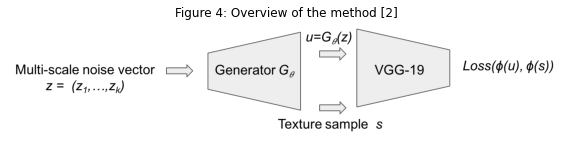

In [6]:
plotImage(Image.open("./Ulyanov16.png"), "Figure 4: Overview of the method [2]", (10,10))


The loss is computed from the Gram matrices of the VGG pre-trained features. More precisely, the loss The loss compares Gram matrices from the groundtruth texture with the ones of the infered image. The complete learning then optimizes:
$$ \min_\theta \mathbb{E}_{z\sim Z} \sum_l\| \Phi_l(G_\theta(z))-\Phi_l(s) \|_2^2, $$

where the Gram matrices $\Phi_l$  of an image $u$ at layer $l$ is given by:
$$\Phi_l(u) = \frac{1}{H_lW_lD_l} \phi_l(u)\phi_l^T(u)$$
with $\phi_l$ the feature after activation at layer $l$.

#### <font color='red'> Question 2 </font> 
Explain this formula and implement it

La matrice de gram mesure la colinéarité des eléments dans la matrice $\phi(u)$. Cette matrice $\phi(u)$ correspond à une des couche de feature obtenue en passant l'image u dans le réseau vgg-19. On normalisera le résultat en le divisant par les dimensions de la couche de features.

In [31]:
# Phi = X*transpose(X)
class GramMatrix(nn.Module): # ne pas pas etre utiliser avec batch_size différent de 1.
    def forward(self, feat):
        b, d, h, w = feat.size() #batch size, channel, height, width
        f = feat.view(b*d,h*w)
        Phi = torch.mm(f,f.t())
        return Phi.div(b*d*h*w)
        
gram_matrix = GramMatrix()
gram_sample_feats = [gram_matrix(feat) for feat in sample_feats]


We will use network architectures hiven in folder TextureNetwork/

In [32]:
from TextureNetwork.models import Pyramid2D

# create generator network
gen = Pyramid2D(ch_in=3, ch_step=8)
if torch.cuda.is_available():
    gen = gen.cuda()

Let us now train this network in order to generate images of size H $\times $ W $\times $ D

#### <font color='red'> Question 3 </font>
Complete the following code in order to train the network to learn to generate a texture similar to the sample

We encourage you to use gradient normalisation during training by applying function *Normalize_gradients.apply* defined in file *my_utils.py* on the VGG features of the generated noise vector. It means that during gradient descent we only consider the direction of the gradient and not its magnitude.  (e.g. Normalize_gradients.apply(feat))

0
0.017580758780241013


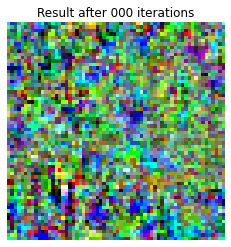

50
0.0007276402902789414


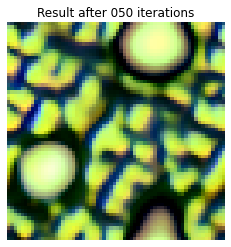

100
0.0005401552189141512


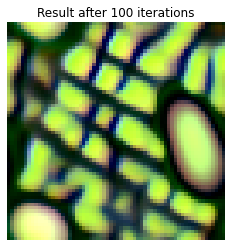

150
0.0003525314969010651


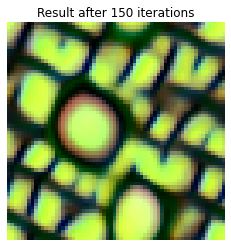

200
0.0002304034715052694


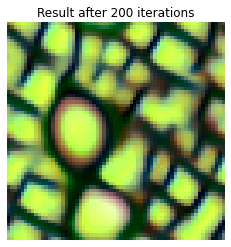

250
0.0001375723659293726


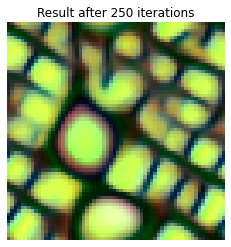

---> lr adjusted to 0.008
300
0.00019404538033995777


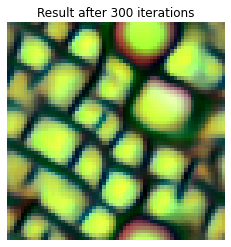

350
9.45084320846945e-05


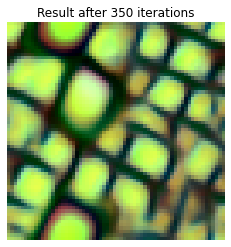

400
0.00012290195445530117


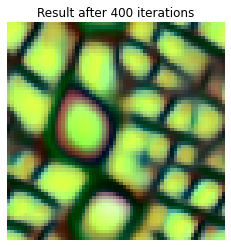

450
0.0001501874503446743


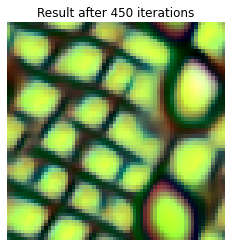

500
0.00012918320135213435


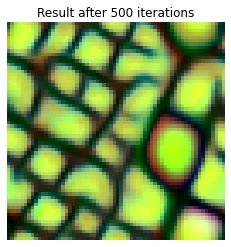

In [33]:
#Save folder
out_folder = "res"
import os
if os.path.exists(out_folder)==False:
    os.mkdir(out_folder)

out_folder_model = "model"
if os.path.exists(out_folder_model)==False:
    os.mkdir(out_folder_model)

#output dimension
H = 64
W = 64 
D = 3
#Learning parameters
N_optim_iter = 500 #number of iteration
save_every = 50 #how often are images saved
save_params = save_every
lambda_loss = 1e5
batch_size = 10
myloss = nn.MSELoss()

#Optimization parameters
learning_rate = 0.01
lr_adjust = 300
lr_decay_coef = 0.8
min_lr = 0.001
optimizer = torch.optim.Adam(gen.parameters(), lr=learning_rate)

#Scales of the noise vector
szH = [H/1,H/2,H/4,H/8,H/16,H/32]
szW = [W/1,W/2,W/4,W/8,W/16,W/32]

#run training
for n_iter in range(N_optim_iter+1):
    optimizer.zero_grad()

    # element by element to allow the use of large training sizes
    for i in range(batch_size):
        #generate multiscale noise
        if torch.cuda.is_available():
            zk = [torch.rand((1,D,int(szh),int(szw)), requires_grad=True, device='cuda') for szh,szw in zip(szH, szW)]
        else:
            zk = [torch.rand((1,D,int(szh),int(szw)), requires_grad=True) for szh,szw in zip(szH, szW)]

        
        g_z = gen(zk)[0,:,:,:].unsqueeze(0)
        if torch.cuda.is_available():
            g_z = g_z.cuda()



        # compute VGG features of image G(z) to compare them with those of the sample
        g_z_feats =  vgg_net(g_z)
        
        # compute loss
        # We encourage you to use gradient normalisation (see above text)
        #COMPLETE
        

  
        
        gram_g_z_feats = [gram_matrix(feat) for feat in g_z_feats]
        
        
        
        loss = 0 
        
        for gram1,gram2 in zip(gram_g_z_feats, gram_sample_feats):
            loss += myloss(gram1,gram2) #MSE

        #print(loss) #Uncomment if you want to see loss at each epochs
        
        #for feat in g_z_feats:
        #   Normalize_gradients.apply(feat)
        
    
        loss.backward() # Calcule le gradient et effectue la descente de gradient.
        loss_iter = loss.item() # .item transforme en nombre.
        
        

        del  loss,  zk, g_z_feats


    if n_iter%save_every==0:
        print(n_iter)
        print(loss_iter)
        usave = postp(g_z.cpu().detach().squeeze())
        plotImage(usave, 'Result after {:03d} iterations'.format(n_iter)) 
        usave.save(out_folder + 'iteration_{:03d}.jpg'.format(n_iter), "JPEG")
    del g_z

    #Update learning rate
    optimizer.step()
    if optimizer.param_groups[0]['lr'] > min_lr:
        if n_iter%lr_adjust == (lr_adjust-1):
            optimizer.param_groups[0]['lr'] = lr_decay_coef * optimizer.param_groups[0]['lr']
            print('---> lr adjusted to '+str(optimizer.param_groups[0]['lr']))
            #print(loss_iter)


# save the network
if os.path.exists(out_folder_model+ '/trained_model.py'):
    os.remove(out_folder_model+ '/trained_model.py')
if os.path.exists(out_folder_model+ '/params.pytorch'):
    os.remove(out_folder_model+ '/params.pytorch')
torch.save(gen, out_folder_model+ '/trained_model.py')
torch.save(gen.state_dict(), out_folder_model+ '/params.pytorch')

#### <font color='red'> Question 4 </font>
Now that the network is trained, apply it to generate new texture images from a random noise image. Comment the results. 

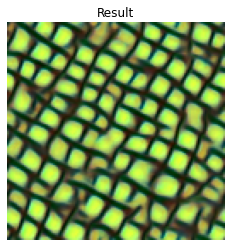

In [34]:
#To load a pretrained network from file
generator  = Pyramid2D(ch_in=3, ch_step=8)
generator.load_state_dict(torch.load('./' + out_folder_model+ '/params.pytorch'))

with torch.no_grad():
    generator.eval()
for param in generator.parameters():
    param.requires_grad = False

H = 128
W = 128

    
szH = [H/1,H/2,H/4,H/8,H/16,H/32]
szW = [W/1,W/2,W/4,W/8,W/16,W/32]    
    
zk = [torch.rand((1,D,int(szh),int(szw)), requires_grad=True) for szh,szw in zip(szH, szW)]

output = generator(zk)[0,:,:,:].unsqueeze(0)
output = postp(output.cpu().detach().squeeze())
plotImage(output, "Result")

 


#### <font color='red'> Question 5 </font>
Experiment with different losses, images, layers, analyse your results, visualise the loss. 


- Sur une image où l'elément de sortie est plus grand que l'image dont on cherche à reproduire la textures, les élèments de cette textures auront l'air plus petits et plus nombreux (Par exemples pour l'exemple des poivrons, on en aura beaucoup plus). En fait, si on compare le résultat et l'image de base dans leur taille réelle, les poivrons auront la même taille, par contre ils seront plus nombreux dans le résultat car l'image est plus grande.
- Le changement de learning_rate peut avoir une influence sur le résultat. En effet, si celui-ci est trop grand (lr = 1 par exemple), alors l'algorithme ne converge pas. En revanche, un learning rate plus petit (lr = 0.01) fera que le réseaux converge plus lentement mais permettra peut-être d'avoir un résultat plus précis après un grand nombre d'itérations. On constate d'ailleurs dans notre exemple que la valeur de la fonction loss est plus faible après 500 itérations avec un lr = 0.01 qu'avec un lr = 0.1, et visuellement le résultat semble plus convaincant.
- Autre élément que l'on peut modifier: la fonction loss. On a utilisé dans les résultats précédents la Mean-Squared Error, on peut par exemple utiliser aussi la norme 1 (erreur absolue). Le résultat que l'on obtient semble correcte bien que peut-être un peu moins précis.